In [1]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict, Literal , Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [2]:
load_dotenv()

True

In [3]:
# Define LLM models for perticular task 
generateor_llm = ChatGroq(model='llama-3.1-8b-instant') # model='llama-3.1-8b-instant'
evaluator_llm = ChatGroq(model='llama-3.1-8b-instant') # model='mixtral-8x7b-32768'
optimizer_llm = ChatGroq(model='llama-3.1-8b-instant') # model='llama-3.1-70b-instinct'


In [4]:
class TweetEvaluationSchema(BaseModel):
    evaluation: Literal['approved','need_improvement'] = Field(...,description="Evaluate Final Result , and give output in only one word either 'approved' or 'need_improvement' with considering all the evaluation criteria . no need to generate any extra output than this. ")
    feedback: str = Field(..., description="Feedback for the tweet by following the mentioned criteria to generate 'feedback' for given tweet .")

In [5]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluationSchema)

In [6]:
# Define State
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal['approved','need_improvement']
    feedback: str
    iterations: int
    max_iterations: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [7]:
# who is working in tech filed and have some experience in tech filed

def generate_tweet(state: TweetState):

    #promot
    message = [
        SystemMessage(content="You are funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, funny yet informative tweet on topic: '{state['topic']}'.

Rules :
- Do Not use question-answer format.
- Max 300 characters .
- Use Observational humor , irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english.
- Can use scenarios to make readers feel relatable with tweet.
""")
    ]

    # send to generator_llm
    responce = generateor_llm.invoke(message).content

    # return responce
    return {'tweet': responce, 'tweet_history': [responce]}


In [8]:


def evaluate_tweet(state: TweetState):

      #promot
    message = [
        SystemMessage(content=f"""You are a very very strict Twitter/X content evaluator.You specialize in evaluating short, tech-focused, humorous tweets written by influencers."""),
        HumanMessage(content=f"""
Evaluate the following tweet:

"{state['tweet']}"


                      
Your job is to evaluate the tweet based on:

1. Humor Quality (Is it genuinely funny, witty, or clever?)
2. Relatability (Can tech audience connect with it?)
3. Clarity (Is it easy to understand?)
4. Engagement Potential (Would people like, retweet, or comment?)
5. Rule Compliance:
   - Not in question-answer format
   - Under 300 characters
   - Uses simple, everyday English

IMPORTANT:
- Reject the tweet if it is not have capability to get score 9 out of 10 level of proficiency 
- Do NOT rewrite the tweet.
- Do NOT generate a new tweet.
- Only evaluate and give output of 'evaluation' in one word either 'approved' or 'need_improvement' nothing more than this as output for 'evaluation'.
- Keep response concise and structured.


Provide structured 'feedback' using the following sections:

Humor Quality:
Relatability:
Clarity:
Engagement Potential:
Rule Compliance:

In Rule Compliance, check:
- Not in question-answer format
- Under 300 characters
- Uses simple, everyday English

IMPORTANT:
- Do NOT rewrite the tweet.
- Do NOT suggest a completely new tweet.
- Only point out strengths and weaknesses.
- Keep feedback concise.
""")
    ]

    responce = structured_evaluator_llm.invoke(message)

    return {'evaluation': responce.evaluation , 'feedback': responce.feedback , 'feedback_history':[responce.feedback] }



In [9]:
def optimize_tweet(state:TweetState):

    message = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. avoid question-answer style and stay under 300 characters""")
    ]

    responce = optimizer_llm.invoke(message).content
    iteration = state['iteration']+1

    return {'tweet': responce,'iteration':iteration, 'tweet_history':[responce]}

In [10]:
def route_evaluation(state: TweetState):

    if state['evaluation']=='approved' or state['iterations'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'need_improvement'

In [11]:
# Define the Graph
graph = StateGraph(TweetState)

# Define the Nodes
graph.add_node('Generate', generate_tweet)
graph.add_node('Evaluate',evaluate_tweet)
graph.add_node('Optimize',optimize_tweet)

# Define Edges
graph.add_edge(START,'Generate')
graph.add_edge('Generate','Evaluate')

graph.add_conditional_edges('Evaluate',route_evaluation, {'approved': END , 'need_improvement':'Optimize'})

graph.add_edge('Optimize','Evaluate')

# Compile the Graph
workflow = graph.compile()


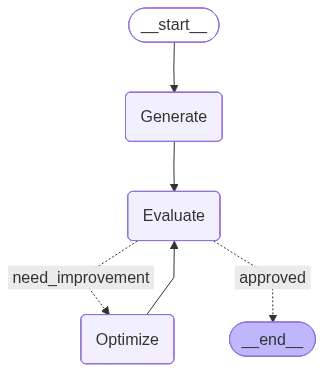

In [201]:
workflow

In [12]:
initial_state = {
    'topic': 'Indian AI Startup' ,
    'iterations': 1,
    'max_iterations': 5
}

workflow.invoke(initial_state)


{'topic': 'Indian AI Startup',
 'tweet': '"Just invested in an Indian AI startup and it\'s \'predicting\' I\'ll order more biryani. Now I\'m wondering if the AI has hacked my grandma\'s WhatsApp. Anyone else\'s AI startup predicting their snack choices? #IndianTech #AISnacks"',
 'evaluation': 'approved',
 'feedback': "Humor Quality: Excellent use of wordplay with 'predicting' and 'hacked'. Relatability: Tech audience can easily connect with the lighthearted AI-themed joke. Clarity: Easy to understand with no confusion. Engagement Potential: People will likely like and retweet due to its humor and relatability. Rule Compliance: Meets all requirements, witty and under 300 characters.",
 'iterations': 1,
 'max_iterations': 5,
 'tweet_history': ['"Just invested in an Indian AI startup and it\'s \'predicting\' I\'ll order more biryani. Now I\'m wondering if the AI has hacked my grandma\'s WhatsApp. Anyone else\'s AI startup predicting their snack choices? #IndianTech #AISnacks"'],
 'feedbac